# 問題導向之資料科學與機器學習應用 - Final Project
### Churn Prediction of Bank Users
## 組名：陳舜寧可我負天下人
### 組員：張孟涵、李艾霓、陳舜寧
#### 2019/07/04
* **1 問題定義**
* **2 資料前處理**
    * 2.1 載入資料
    * 2.2 檢查缺失值
    * 2.3 檢查離群值
* **3 特徵處理與分析**
    * 3.1 移除對預測沒有幫助的變項
    * 3.2 轉換類別資料 (虛擬變數 Dummy Variable)
    * 3.3 資料分析
* **4 建模型**
    * 4.1 CatBoost
    * 4.2 XGBoost
    * 4.3 LightGBM
    * 4.4 Ensemble
* **5 結果統整與改進**
    * 5.1 CatBoost, XGB, LGBM 比較
    * 5.2 三者預測相關性



#### 資料連結：https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

## 1. 問題定義
　　這個資料集中，主要的問題是<font color='red'>預測銀行客戶是否會離開（Exited）</font>，而我們有的columns如下：
- RowNumber 相當於每個row的index，不具意義
- CustomerId 每位客戶獨有的id，亦不具意義
- Surname 客戶的姓氏
- CreditScore 信用評分，分數越高表示客戶有越好的銀行行為
- Geography 地區
- Gender 性別
- Age 年齡
- Tenure 客戶擁有的不動產
- Balance 銀行帳戶中的存款
- NumOfProducts 金融商品數
- HasCrCard 是否有信用卡
- IsActiveMember 是否為活躍會員
- EstimatedSalary 估計的薪水
- Exited 最終是否離開銀行


### • 潛在問題
1. 這份資料確切的來源其實並不是很明確，是否真實可信須持保留態度。
2. 對於「離開」沒有一個確切的定義。
3. 資料蒐集的時間無從得知，是在某一時間點下蒐集了全部的資料，或是客戶進入銀行後一段固定時間後蒐集資料，這之間有些不同。
4. 資料集內「未離開」的客戶是否可能是在未來離開？

上述幾點都影響了我們該如何看待這份資料，但資訊不夠完整。

In [65]:
# Load in our libraries
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Going to try these models
import xgboost as xgb
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate

　
## 2. 資料前處理
### 2.1 載入資料

In [2]:
dataset = pd.read_csv('Churn_Modelling.csv')
dataset.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


### 2.2 檢查缺失值

In [3]:
# Check for Null values
dataset.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

<font color='red'>資料中沒有任何缺失值。</font>

### 2.3 檢查離群值

In [6]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from CreditScore, Age, Balance and EstimatedSalary
Outliers_to_drop = detect_outliers(dataset,1,["CreditScore","Age","Balance","EstimatedSalary"])

dataset.loc[Outliers_to_drop] # Show the outliers rows

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


<font color='red'>資料中沒有任何離群值。</font>

　
## 3. 特徵處理與分析
### 3.1 移除對預測沒有幫助的變項

In [7]:
dataset.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

RowNumber, CustomerId兩者都屬於每人獨有的編號，應不具意義；而Surname我們亦假定其與個體之行為無關，可能誤導預測結果，因此<font color='red'>將以上3個變數從資料中移除</font>。

In [8]:
dataset.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
dataset.head(3)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


### 3.2 轉換類別資料 (虛擬變數 Dummy Variable)

In [9]:
dataset = pd.get_dummies(dataset)
dataset.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0,1,0


　
### 3.3 資料分析
#### 離開與未離開之比例

Percentage of Exited: 20.369999999999997 %


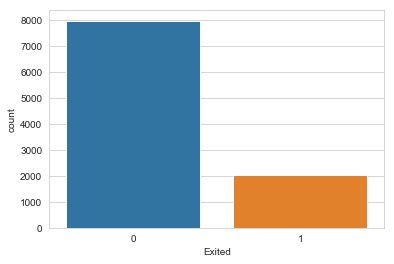

In [11]:
target = dataset['Exited']
sns.set_style('whitegrid')
sns.countplot(target)
print('Percentage of Exited:',dataset.Exited.sum()/dataset.Exited.count()*100,'%')

#### 變項間相關性

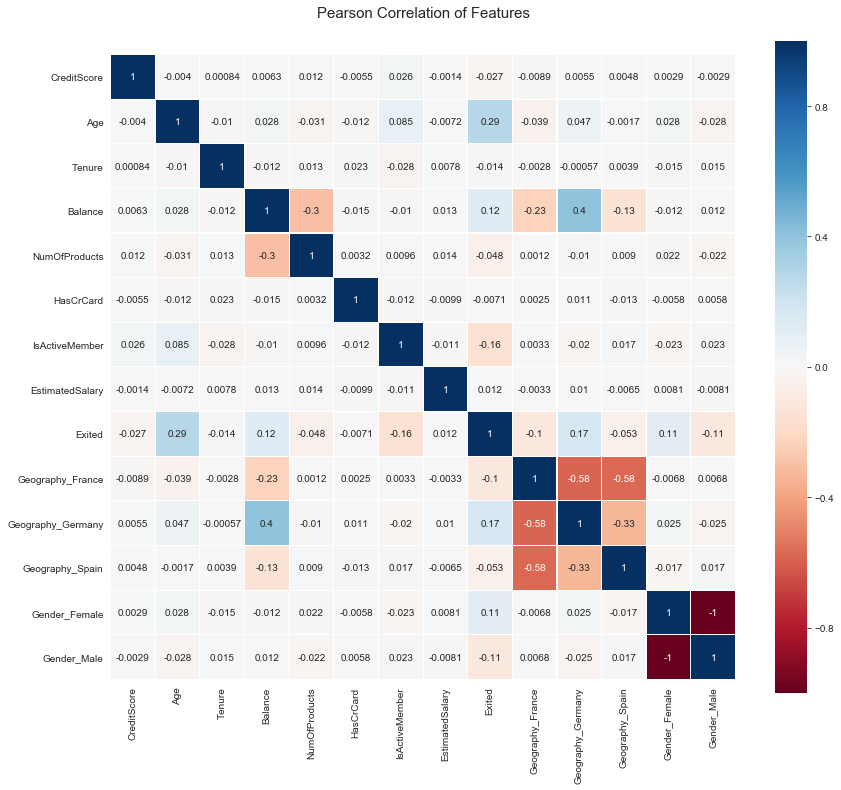

In [12]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(dataset.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

我們可以發現，在所有變項中僅有年齡與是否離開銀行具有較顯著的相關性。
(但並不代表其他變項是沒有用處的)

稍後我們將<font color='red'>依相關程度作為順序</font>一一檢視。

#### Age

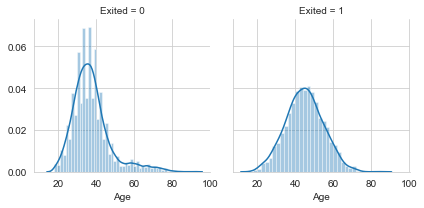

In [13]:
g = sns.FacetGrid(dataset, col='Exited')
g = g.map(sns.distplot, "Age")

可以發現離開及未離開兩者的年齡分配具有差異，我們再將圖疊合：

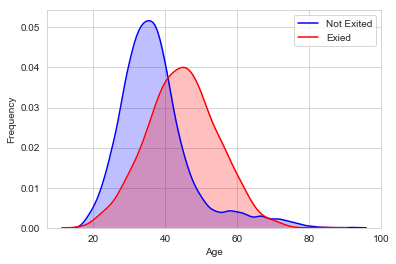

In [15]:
# Explore Age distibution 
g = sns.kdeplot(dataset["Age"][(dataset["Exited"] == 0) & (dataset["Age"].notnull())], color="Blue", shade = True)
g = sns.kdeplot(dataset["Age"][(dataset["Exited"] == 1) & (dataset["Age"].notnull())], ax =g, color="Red", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Exited","Exied"])

「未離開」的分配相較於「離開」更右偏了不少。

#### Geography

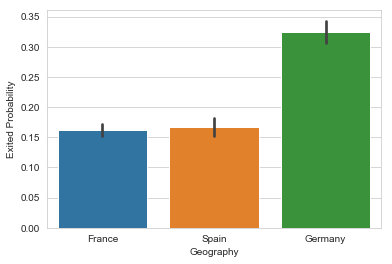

In [16]:
df = pd.read_csv('Churn_Modelling.csv')
g = sns.barplot(x="Geography",y="Exited",data=df)
g = g.set_ylabel("Exited Probability")

可以發現相較於另外兩個地區，Germany的顧客有較大的機率會離開。

#### IsActiveMember

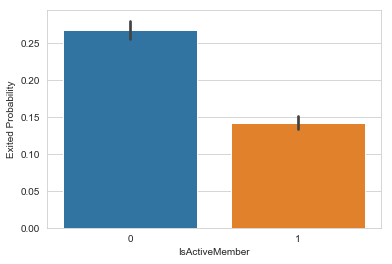

In [17]:
g = sns.barplot(x="IsActiveMember",y="Exited",data=dataset)
g = g.set_ylabel("Exited Probability")

不意外的，交易活動較頻繁的顧客有較低的離開可能性。

#### Balance

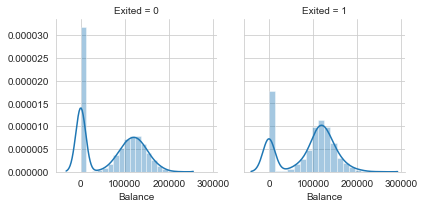

In [18]:
g = sns.FacetGrid(dataset, col='Exited')
g = g.map(sns.distplot, "Balance")

資料的Balance呈現一種特殊的分配情況，在0的地方有一個高峰，除去0之外的地方則近似一個常態分配。一樣的我們將圖疊合：

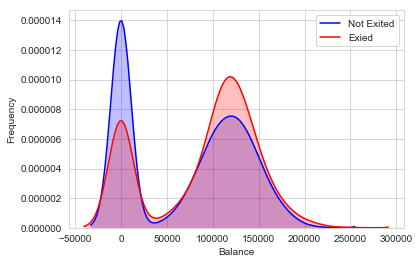

In [19]:
g = sns.kdeplot(dataset["Balance"][(dataset["Exited"] == 0) & (dataset["Balance"].notnull())], color="Blue", shade = True)
g = sns.kdeplot(dataset["Balance"][(dataset["Exited"] == 1) & (dataset["Balance"].notnull())], ax =g, color="Red", shade= True)
g.set_xlabel("Balance")
g.set_ylabel("Frequency")
g = g.legend(["Not Exited","Exied"])

兩者的高峰出現在不一樣的地方。
#### Gender

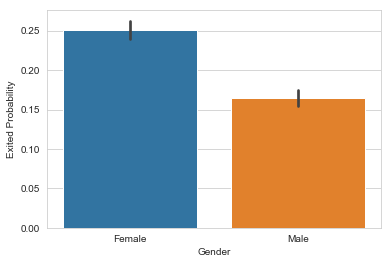

In [20]:
g = sns.barplot(x="Gender",y="Exited",data=df)
g = g.set_ylabel("Exited Probability")

女性離開的機率較男性來得大。

#### NumOfProducts

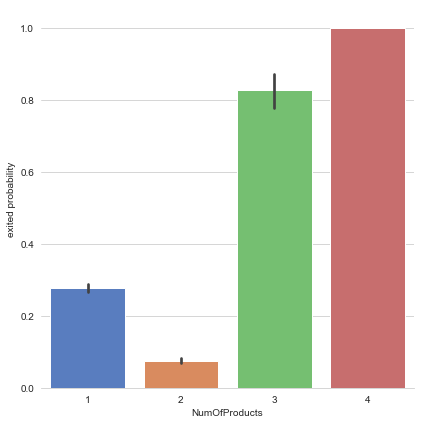

In [22]:
g = sns.factorplot(x="NumOfProducts",y="Exited",data=dataset,kind="bar", size = 6, palette = "muted")
g.despine(left=True)
g = g.set_ylabels("exited probability")

擁有不同產品數量的顧客離開的機率具有差異。需注意的是，持有1~2項產品的顧客人數是遠大於持有3~4項產品的顧客人數的：

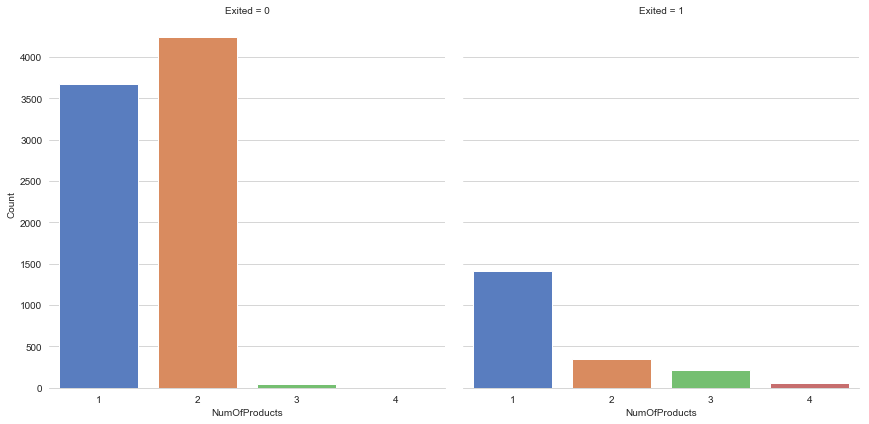

In [23]:
g = sns.factorplot("NumOfProducts", col="Exited",  data=dataset,
                   size=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

#### CreditScore

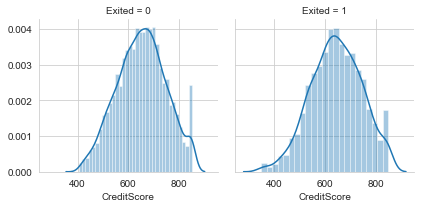

In [24]:
g = sns.FacetGrid(dataset, col='Exited')
g = g.map(sns.distplot, "CreditScore")

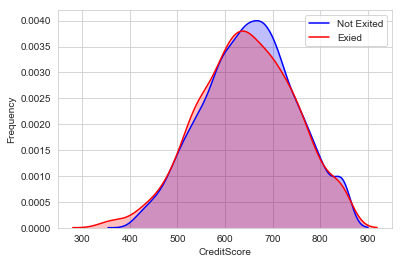

In [25]:
g = sns.kdeplot(dataset["CreditScore"][(dataset["Exited"] == 0) & (dataset["CreditScore"].notnull())], color="Blue", shade = True)
g = sns.kdeplot(dataset["CreditScore"][(dataset["Exited"] == 1) & (dataset["CreditScore"].notnull())], ax =g, color="Red", shade= True)
g.set_xlabel("CreditScore")
g.set_ylabel("Frequency")
g = g.legend(["Not Exited","Exied"])

#### Tenure

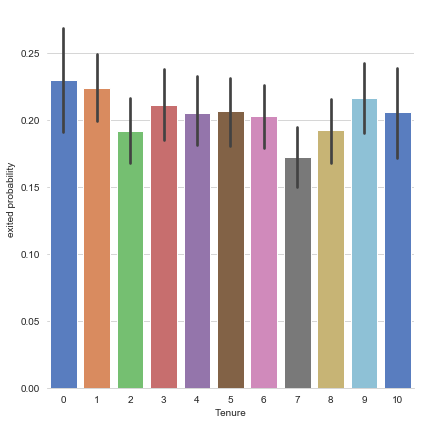

In [26]:
g = sns.factorplot(x="Tenure", y="Exited", data=dataset, kind="bar", size = 6, palette = "muted")
g.despine(left=True)
g = g.set_ylabels("exited probability")

#### EstimatedSalary

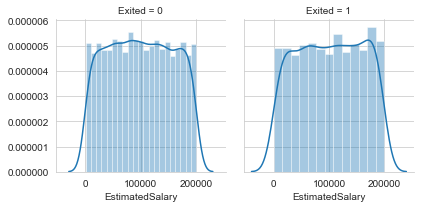

In [27]:
g = sns.FacetGrid(dataset, col='Exited')
g = g.map(sns.distplot, "EstimatedSalary")

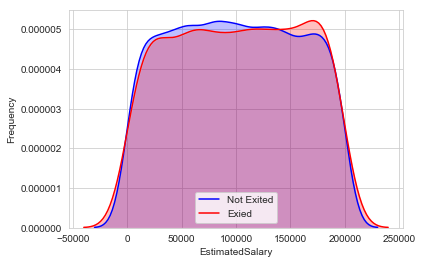

In [28]:
g = sns.kdeplot(dataset["EstimatedSalary"][(dataset["Exited"] == 0) & (dataset["EstimatedSalary"].notnull())], color="Blue", shade = True)
g = sns.kdeplot(dataset["EstimatedSalary"][(dataset["Exited"] == 1) & (dataset["EstimatedSalary"].notnull())], ax =g, color="Red", shade= True)
g.set_xlabel("EstimatedSalary")
g.set_ylabel("Frequency")
g = g.legend(["Not Exited","Exied"])

#### HasCrCard

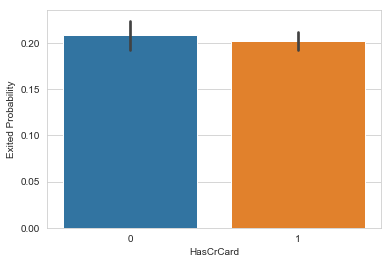

In [29]:
g = sns.barplot(x="HasCrCard",y="Exited",data=dataset)
g = g.set_ylabel("Exited Probability")

## 4. 建模型
### 4.1 CatBoost
CatBoost本身就可以處理類別資料，這裡我們是直接把沒有處理過的資料丟進去。

In [89]:
df = pd.read_csv('Churn_Modelling.csv')
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

X = df.drop('Exited',axis=1)
y = df.Exited

random_state = 123 ## here
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_train.head(3)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
9216,724,France,Male,30,10,0.0,2,1,1,54265.55
7324,607,France,Female,39,10,0.0,3,1,0,132741.13
918,784,Spain,Male,35,3,0.0,2,0,0,81483.64


In [90]:
# CatBoost
# 使用預設參數，只給予'哪些column是屬於類別變數'
CB = CatBoostClassifier(cat_features=[1,2,7,8],silent=True)
CB.fit(X_train,y_train)
cb_predict = CB.predict(X_test)

cross_validate(CB,X,y,cv=5)

{'fit_time': array([51.96525764, 50.81142783, 50.11490464, 55.38204575, 54.48928618]),
 'score_time': array([0.01496077, 0.01592422, 0.01495886, 0.01495886, 0.01994586]),
 'test_score': array([0.87006497, 0.87406297, 0.8635    , 0.87093547, 0.85792896]),
 'train_score': array([0.88273534, 0.88023503, 0.8815    , 0.88088989, 0.88601425])}

### 4.2 XGBoost
對於CatBoost以外的模型，我們則要給予處理過的資料(dummy variable)。

In [84]:
df = pd.read_csv('Churn_Modelling.csv')
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
df = pd.get_dummies(df)
df.drop(['Geography_France', 'Gender_Female'], axis=1, inplace=True)
X = df.drop(['Exited'], axis=1)
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
X_train.head(3)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
9216,724,30,10,0.0,2,1,1,54265.55,0,0,1
7324,607,39,10,0.0,3,1,0,132741.13,0,0,0
918,784,35,3,0.0,2,0,0,81483.64,0,1,1


In [85]:
# XGBoost
XGB = xgb.XGBClassifier()
XGB.fit(X_train,y_train)
xgb_predict = XGB.predict(X_test)

cross_validate(XGB,X,y,cv=5)

{'fit_time': array([0.79387689, 0.69114971, 0.68716168, 0.6981678 , 0.68815875]),
 'score_time': array([0.00797915, 0.00798082, 0.0079782 , 0.0069468 , 0.00897622]),
 'test_score': array([0.86256872, 0.87156422, 0.858     , 0.87243622, 0.85692846]),
 'train_score': array([0.87235904, 0.86985873, 0.875375  , 0.86964129, 0.87264092])}

### 4.3 LGBM

In [86]:
# LightGBM
LGBM = LGBMClassifier()
LGBM.fit(X_train,y_train)
lgbm_predict = LGBM.predict(X_test)

cross_validate(LGBM,X,y,cv=5)

{'fit_time': array([0.2114346 , 0.217417  , 0.22340035, 0.29620457, 0.21841407]),
 'score_time': array([0.02289915, 0.02792454, 0.02593207, 0.0319171 , 0.02493191]),
 'test_score': array([0.86556722, 0.86606697, 0.8565    , 0.86543272, 0.85942971]),
 'train_score': array([0.91373922, 0.91211401, 0.911625  , 0.91526059, 0.91713536])}

### 4.4 Ensemble

In [91]:
print('CatBoost Acc:')
print(accuracy_score(y_test, cb_predict))

print('\nXGBoost Acc:')
print(accuracy_score(y_test, xgb_predict))

print('\nLightGBM Acc:')
print(accuracy_score(y_test, lgbm_predict))

result = np.where(cb_predict + xgb_predict + lgbm_predict >= 2, 1, 0)
print('\nVoting Acc:')
print(accuracy_score(y_test, result))

CatBoost Acc:
0.868

XGBoost Acc:
0.8615

LightGBM Acc:
0.8625

Voting Acc:
0.8665


## 5. 結果統整與改進
### 5.1 CatBoost, XGB, LGBM 比較

In [97]:
df = pd.DataFrame([[52.55,0.71,0.23],
                   [0.8823,0.872,0.914],
                   [0.8673,0.8643,0.8626]],
                  index=['Fit time','Train score','Test score'],
                  columns=['CatBoost','XGBoost','LightGBM'])
df

,CatBoost,XGBoost,LightGBM
Fit time,52.5500,0.7100,0.2300
Train score,0.8823,0.8720,0.9140
Test score,0.8673,0.8643,0.8626


### 5.2 三者預測相關性

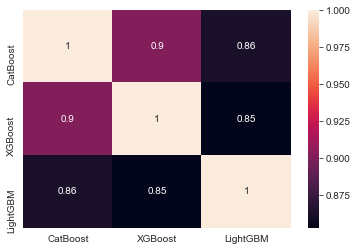

In [96]:
df = pd.DataFrame(cb_predict, columns=['CatBoost'])
df['XGBoost'] = xgb_predict
df['LightGBM'] = lgbm_predict
sns.heatmap(df.astype(float).corr(), annot=True)

　　其實三個分類模型的預測結果相關性還是偏高的，這也可能是Ensemble的結果沒有更好的原因，或許使用多個較弱而較不那麼相似的分類器來做ensemble效果會比我們使用這三者還要好。在未來若希望再進一步提升結果，這將是一個可以著手的地方。


# 修課心得與建議
　　五天的課程進度真的很快（其實是四天），但是有實做到的部分卻感覺很少，尤其是到後面的深度學習，我們其實不太有能力可以自己架出一個理想中的model。既然課程是問題導向，其實我們在一開始會比較期待有很多實際練習的部分，不過後來課程實際的走向並不是這樣。覺得可以把課程的內容減少一些，讓實作的部分可以跟上課程進度，聽完理論就學如何用code來實現，不然其實光是聽了理論的東西，而不知道該如何做出來，對我們其實並沒有太大的幫助。

　　很喜歡每天的助教課，助教們都講得很清楚、易懂，而且還會準備一些小小的練習，讓我們能更快上手，在練習的過程其實也會得到一些小小的成就感，覺得助教課的質量真的比一般還要高出很多很多。而且課堂的助教們都很親切，問問題都很有耐心的幫忙解決，真的很棒。

　　最後是作業的部分，不知道是不是出作業的助教和上課的助教不一樣，作業總是和課程範圍對不上，例如上課講解NN用keras，作業卻是用pytorch寫，總覺得中間有一些障礙，幾乎每份作業都會有讓人覺得很疑惑的地方，或許把助教課的練習當成作業會比較好。

　　很感謝老師和助教這幾天用心的教學，在短短幾天之內和大家一起完成這份final project真的很不可思議（真的是一天就生出了很多東西），除了課堂內的學習之外，也激發我們透過網路的資源、別人寫的kernal來幫助自己進步，最後的收穫其實比原本想的還要更多。